In [9]:
import os
import random
import shutil
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO
import torch

In [10]:
import os
import random
import numpy as np
from PIL import Image, ImageEnhance, ImageFilter, ImageDraw

# === CONFIG ===
INPUT_DIR = "glyph_images"
SYNTH_IMG_DIR = "synthetic_sentences"
SYNTH_LBL_DIR = "synthetic_sentences_labels"
YOLO_DATA_DIR = "yolo_dataset"
CANVAS_SIZE = (1500, 300)
GLYPHS_PER_SENTENCE = 10
NUM_SENTENCES = 10

# === PREPARE FOLDERS ===
os.makedirs(SYNTH_IMG_DIR, exist_ok=True)
os.makedirs(SYNTH_LBL_DIR, exist_ok=True)
os.makedirs(os.path.join(YOLO_DATA_DIR, "images", "train"), exist_ok=True)
os.makedirs(os.path.join(YOLO_DATA_DIR, "labels", "train"), exist_ok=True)

# === LOAD GLYPHS ===
# Assuming this part is in a cell after INPUT_DIR is defined
glyph_files = sorted([f for f in os.listdir(INPUT_DIR) if f.endswith(('.png', '.jpg', '.jpeg'))])
glyph_classes = {f: idx for idx, f in enumerate(glyph_files)}
num_classes = len(glyph_classes)
print(f"Detected {num_classes} glyph classes.")

# === UTILITY: Add background noise ===
def add_background_noise(image, intensity=15):
    noise = np.random.randint(0, intensity, (image.height, image.width), dtype='uint8')
    img_np = np.array(image).astype(np.int16)
    noisy_image = img_np + noise
    noisy_image = np.clip(noisy_image, 0, 255).astype('uint8')
    return Image.fromarray(noisy_image)

# === UTILITY: Add smaller, sparser grey masking rectangles ===
def add_grey_mask(image):
    draw = ImageDraw.Draw(image)
    num_masks = random.randint(60, 80)
    for _ in range(num_masks):
        w = random.randint(image.width // 60, image.width // 40)  # range instead of fixed
        h = random.randint(image.height // 60, image.height // 40)
        x0 = random.randint(0, max(image.width - w, 0))
        y0 = random.randint(0, max(image.height - h, 0))
        x1 = x0 + w
        y1 = y0 + h
        shade = random.randint(100, 200)
        draw.rectangle([x0, y0, x1, y1], fill=shade)
    return image

# === GENERATE SYNTHETIC SENTENCES ===
for i in range(NUM_SENTENCES):
    canvas = Image.new('L', CANVAS_SIZE, color=255)
    x_offset = 5
    bboxes = []
    # random.shuffle(glyph_files)  # no need to shuffle here since you sample anyway

    for glyph_name in random.sample(glyph_files, GLYPHS_PER_SENTENCE):

        class_id = glyph_classes[glyph_name]
        glyph_path = os.path.join(INPUT_DIR, glyph_name)
        glyph = Image.open(glyph_path).convert('L')

        # Contrast reduction and blur
        glyph = ImageEnhance.Contrast(glyph).enhance(random.uniform(0.5, 0.9))
        glyph = glyph.filter(ImageFilter.GaussianBlur(radius=random.uniform(0.5, 1.5)))

        # Rotation
        angle = random.uniform(-10, 10)
        glyph = glyph.rotate(angle, expand=True, fillcolor=255)

        # Crop non-white regions
        glyph_np = np.array(glyph)
        mask = glyph_np < 250
        if not np.any(mask):
            continue
        coords = np.argwhere(mask)
        y0, x0 = coords.min(axis=0)
        y1, x1 = coords.max(axis=0) + 1
        cropped = glyph.crop((x0, y0, x1, y1))

        # Resize with scale factor
        max_height = CANVAS_SIZE[1] - 10
        scale = random.uniform(0.8, 1.2)
        if cropped.height > max_height:
            scale *= max_height / cropped.height
        new_size = (int(cropped.width * scale), int(cropped.height * scale))
        cropped = cropped.resize(new_size, resample=Image.BILINEAR)

        # Check horizontal space
        if x_offset + cropped.width > CANVAS_SIZE[0]:
            break  # Stop placing glyphs if it doesn't fit

        # Vertical jitter
        y_jitter = random.randint(-3, 3)
        y_offset = (CANVAS_SIZE[1] - cropped.height) // 2 + y_jitter

        # Paste glyph
        canvas.paste(cropped, (x_offset, y_offset))

        # Bounding box (normalized coords) - clamp to [0,1]
        bbox_x_center = (x_offset + cropped.width / 2) / CANVAS_SIZE[0]
        bbox_y_center = (y_offset + cropped.height / 2) / CANVAS_SIZE[1]
        bbox_width = cropped.width / CANVAS_SIZE[0]
        bbox_height = cropped.height / CANVAS_SIZE[1]

        # Clamp bbox values to [0,1] to avoid out-of-bounds errors
        bbox_x_center = min(max(bbox_x_center, 0), 1)
        bbox_y_center = min(max(bbox_y_center, 0), 1)
        bbox_width = min(max(bbox_width, 0), 1)
        bbox_height = min(max(bbox_height, 0), 1)

        bboxes.append((class_id, bbox_x_center, bbox_y_center, bbox_width, bbox_height))

        # Update x_offset with positive increment
        x_offset += cropped.width + random.randint(10, 15)

    # Add visual effects
    canvas = add_grey_mask(canvas)
    canvas = add_background_noise(canvas, intensity=15)

    # Save image and label
    img_path = os.path.join(SYNTH_IMG_DIR, f"sentence_{i}.png")
    canvas.convert("RGB").save(img_path)

    label_path = os.path.join(SYNTH_LBL_DIR, f"sentence_{i}.txt")
    with open(label_path, 'w') as f:
        for bbox in bboxes:
            f.write(f"{bbox[0]} {bbox[1]:.6f} {bbox[2]:.6f} {bbox[3]:.6f} {bbox[4]:.6f}\n")

print("✅ Synthetic sentences generated with glyph bounds checking.")


Detected 1024 glyph classes.
✅ Synthetic sentences generated with glyph bounds checking.


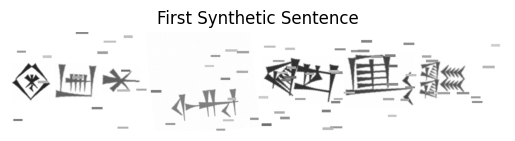

In [11]:
first_image_path = os.path.join(SYNTH_IMG_DIR, "sentence_0.png")

# Load and display the image
img = Image.open(first_image_path)
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.title("First Synthetic Sentence")
plt.show()

In [12]:
# === DATA ORGANIZATION AND SPLIT (Your second snippet) ===
print("Organizing and splitting dataset...")
# Create YOLO dataset folder structure
for split in ["train", "val"]:
    os.makedirs(os.path.join(YOLO_DATA_DIR, "images", split), exist_ok=True)
    os.makedirs(os.path.join(YOLO_DATA_DIR, "labels", split), exist_ok=True)

# Get and shuffle image filenames from the temporary generation directory
all_filenames = [fn for fn in os.listdir(SYNTH_IMG_DIR) if fn.endswith(".png")]
random.shuffle(all_filenames)

# Split into train and val sets
val_size = int(len(all_filenames) * 0.2)
val_files = set(all_filenames[:val_size])
train_files = set(all_filenames[val_size:])

# Function to copy files
def copy_files(filenames, split):
    for fn in filenames:
        base = os.path.splitext(fn)[0]
        img_src = os.path.join(SYNTH_IMG_DIR, fn)
        lbl_src = os.path.join(SYNTH_LBL_DIR, f"{base}.txt")
        img_dst = os.path.join(YOLO_DATA_DIR, "images", split, fn)
        lbl_dst = os.path.join(YOLO_DATA_DIR, "labels", split, f"{base}.txt")

        if os.path.exists(lbl_src): # Only copy if label exists
            shutil.copy(img_src, img_dst)
            shutil.copy(lbl_src, lbl_dst)
        else:
            print(f"Warning: Missing label file for {fn}. Skipping.")

copy_files(train_files, "train")
copy_files(val_files, "val")

print(f"✅ YOLO dataset split into {len(train_files)} train and {len(val_files)} val samples.")


Organizing and splitting dataset...
✅ YOLO dataset split into 8 train and 2 val samples.


In [13]:
# === GENERATE data.yaml (Your first snippet, made dynamic) ===
print("Generating glyphs-seg.yaml...")
yaml_txt = f"""
path: {os.path.abspath(YOLO_DATA_DIR)}
train: images/train
val: images/val

nc: {num_classes}
names:
"""

# Dynamically generate names based on your glyph_classes
# Ensure the names are ordered by their class ID
class_names_ordered = [f_name.split('.')[0] for f_name, idx in sorted(glyph_classes.items(), key=lambda item: item[1])]

for cid, name in enumerate(class_names_ordered):
    yaml_txt += f"  {cid}: {name}\n"

# If you prefer 'Glyph_X' naming, uncomment the following and comment the above loop:
# for cid in range(num_classes):
#     yaml_txt += f"  {cid}: Glyph_{cid}\n"


with open(os.path.join(YOLO_DATA_DIR, "glyphs-seg.yaml"), "w") as f:
    f.write(yaml_txt)

print("✅ glyphs-seg.yaml generated.")



Generating glyphs-seg.yaml...
✅ glyphs-seg.yaml generated.


In [14]:

# ─── TRAIN SEGMENTATION MODEL ─────────────────────────────────────────────────
model = YOLO("yolov8n.pt", task="detect")

# Move to GPU if available
if torch.cuda.is_available():
    model.to("cuda")
    print("🔌 Using GPU:", torch.cuda.get_device_name(0))
else:
    print("⚠️ CUDA not available—falling back to CPU")

model.train(
    data=os.path.join(YOLO_DATA_DIR, "glyphs-seg.yaml"),
    epochs=4,
    imgsz=640,
    batch=64,
    patience=10,
    workers=8,     # parallelize data loading
    # no need to pass `device=` since model is already on cuda (or cpu)
)

# ─── TRAIN DETECTION MODEL ────────────────────────────────────────────────────
model_save_path = "models/glyph_detector.pt"
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)

best_weights = "runs/detect/train/weights/best.pt"
if os.path.exists(best_weights):
    shutil.copy(best_weights, model_save_path)
    print("✅ Done: synthetic data with jitter & segmentation training complete!")
    print(f"✅ Model saved to: {model_save_path}")
else:
    print("⚠️ Training might not have produced weight files yet.")
    print("Please check 'runs/segment/train/weights/' directory after training completes.")


100%|██████████| 6.25M/6.25M [00:04<00:00, 1.57MB/s]


⚠️ CUDA not available—falling back to CPU
New https://pypi.org/project/ultralytics/8.3.142 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.127  Python-3.12.10 torch-2.5.1+cpu CPU (11th Gen Intel Core(TM) i7-1195G7 2.90GHz)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=64, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=yolo_dataset\glyphs-seg.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=4, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, 

train: Scanning C:\Users\stras\Documents\GitHub\AI-project\yolo_dataset\labels\train... 8 images, 0 backgrounds, 0 corrupt: 100%|██████████| 8/8 [00:00<00:00, 659.57it/s]

train: New cache created: C:\Users\stras\Documents\GitHub\AI-project\yolo_dataset\labels\train.cache
val: Fast image access  (ping: 0.10.0 ms, read: 18.71.7 MB/s, size: 204.0 KB)



val: Scanning C:\Users\stras\Documents\GitHub\AI-project\yolo_dataset\labels\val... 2 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2/2 [00:00<00:00, 983.65it/s]

val: New cache created: C:\Users\stras\Documents\GitHub\AI-project\yolo_dataset\labels\val.cache


Plotting labels to runs\detect\train\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=1e-05, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\detect\train
Starting training for 4 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/4         0G       2.37        6.9      1.838        112        640: 100%|██████████| 1/1 [00:09<00:00,  9.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.42s/it]

                   all          2         15          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/4         0G      2.395      6.953      1.732        133        640: 100%|██████████| 1/1 [00:08<00:00,  8.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.04it/s]

                   all          2         15          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/4         0G      2.212      6.944      1.831         91        640: 100%|██████████| 1/1 [00:07<00:00,  7.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.81it/s]

                   all          2         15          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/4         0G      2.229      6.878      1.879        111        640: 100%|██████████| 1/1 [00:07<00:00,  7.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.42it/s]

                   all          2         15          0          0          0          0



4 epochs completed in 0.011 hours.
Optimizer stripped from runs\detect\train\weights\last.pt, 44.4MB
Optimizer stripped from runs\detect\train\weights\best.pt, 44.4MB

Validating runs\detect\train\weights\best.pt...
Ultralytics 8.3.127  Python-3.12.10 torch-2.5.1+cpu CPU (11th Gen Intel Core(TM) i7-1195G7 2.90GHz)
Model summary (fused): 72 layers, 22,062,296 parameters, 0 gradients, 26.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.26it/s]


                   all          2         15          0          0          0          0
                 73758          1          1          0          0          0          0
                 74028          1          1          0          0          0          0
                 74049          1          1          0          0          0          0
                 74053          1          1          0          0          0          0
                 74056          1          1          0          0          0          0
                 74061          1          1          0          0          0          0
                 74085          1          1          0          0          0          0
                 74167          1          1          0          0          0          0
                 74224          1          1          0          0          0          0
                 74329          1          1          0          0          0          0
                 7441


0: 128x640 (no detections), 73.5ms
Speed: 3.3ms preprocess, 73.5ms inference, 1.0ms postprocess per image at shape (1, 3, 128, 640)


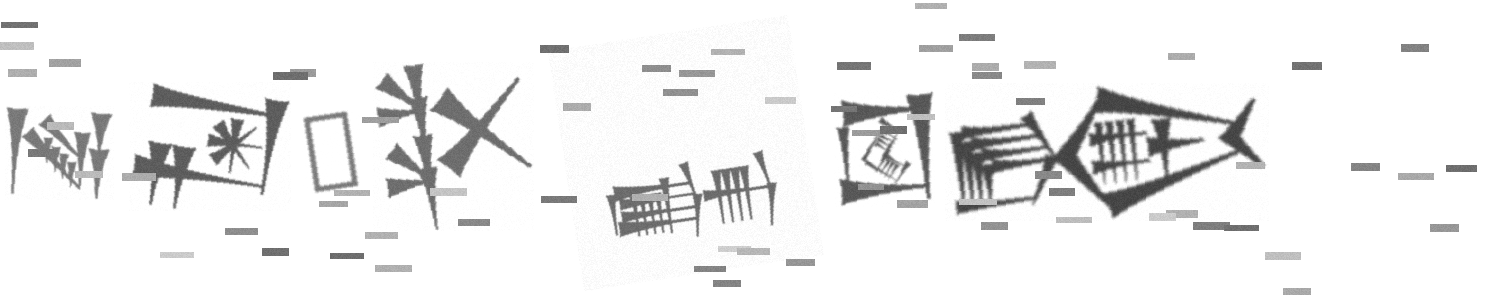

✅ Done: Testing complete, results displayed!


In [15]:
import cv2
import numpy as np
from PIL import Image
from IPython.display import display

# ─── PARAMETERS ────────────────────────────────────────────────────────────────
TEST_IMG_PATH = "yolo_dataset/images/train/sentence_1.png"  # Path to a single test image

# ─── TEST PREDICTIONS ON SINGLE IMAGE ─────────────────────────────────────────
def test_model_on_image(img_path):
    # Load the test image
    img = Image.open(img_path)
    
    # Perform segmentation prediction
    results = model(img)  # Use the pre-trained model
    
    # The results are now a list of detections
    result = results[0]  # The first (and only) result
    
    # Get predictions (boxes, scores, etc.)
    boxes = result.boxes.xyxy.cpu().numpy()  # Bounding boxes (xyxy format)
    confidences = result.boxes.conf.cpu().numpy()  # Confidence scores
    class_ids = result.boxes.cls.cpu().numpy()  # Class IDs
    
    # Convert image for visualization (RGB -> BGR for OpenCV)
    img_cv2 = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    
    # Draw predictions on the image
    for box, conf, class_id in zip(boxes, confidences, class_ids):
        x1, y1, x2, y2 = map(int, box)
        color = (0, 255, 0)  # Green color for bounding box
        cv2.rectangle(img_cv2, (x1, y1), (x2, y2), color, 2)
        
        # Draw label and confidence
        label = f"Glyph_{int(class_id)}: {conf:.2f}"
        cv2.putText(img_cv2, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    # Convert back to RGB for displaying with PIL
    img_rgb = cv2.cvtColor(img_cv2, cv2.COLOR_BGR2RGB)
    img_pil = Image.fromarray(img_rgb)
    
    # Display in Jupyter Notebook
    display(img_pil)

# Test the model on the single image
test_model_on_image(TEST_IMG_PATH)

print("✅ Done: Testing complete, results displayed!")
